<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 84 (delta 42), reused 25 (delta 10), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [0]:
import time

import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets

In [3]:
BATCH_SIZE = 512
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.view(-1),  # Flatten.
    lambda x: distributions.Bernoulli(probs=x).sample()])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class MaskedLinear(nn.Linear):
  """A Linear layer with masks that turn off some of the layer's weights."""

  def __init__(self, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer('mask', torch.ones((out_features, in_features)))

  def set_mask(self, mask):
    self.mask.data.copy_(mask)

  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)


class MADE(nn.Module):
  """Implementation of the Masked Autoencoder Distribution Estimator (MADE).

  MADE is a regular, fully-connected autoencoder with a connectivity pattern 
  that respects autoregressive constraints, i.e., for any ordering of the 
  inputs, each input is constructed only from the previous inputs. This property 
  allows MADE to model P(X) by decomposing it as the product p(x_i | x_{j<i}).
  Interestingly, this means that MADE can turn any regular autoencoder into a 
  powerful generative model.

  For full details, see the paper by Germain et al. (2015).
  """

  def __init__(self, input_dim, hidden_dims=None, n_masks=1):
    """Initializes a new MADE instance.
    
    Args:
      input_dim: The dimensionality of the input.
      hidden_dims: A list containing the number of units for each hidden layer.
      n_masks: The total number of distinct masks to use during training/eval.
    """
    super().__init__()
    self._input_dim = input_dim
    self._dims = [self._input_dim] + (hidden_dims or []) + [self._input_dim]
    self._n_masks = n_masks
    self._mask_seed = 0

    layers = []
    for i in range(len(self._dims) - 1):
      in_dim, out_dim = self._dims[i], self._dims[i + 1]
      layers.append(MaskedLinear(in_dim, out_dim))
      layers.append(nn.ReLU())
    layers[-1] = nn.Sigmoid()  # Output is binary. 
    self._net = nn.Sequential(*layers)

  def _sample_masks(self):
    """Samples a new set of autoregressive masks.

    Only 'self._n_masks' distinct sets of masks are sampled after which the mask
    sets are rotated through in the order in which they were sampled. In 
    principle, it's possible to generate the masks once and cache them. However,
    this can lead to memory issues for large 'self._n_masks' or models many
    parameters. Finally, sampling the masks is not that computationally 
    expensive. 

    Returns:
      A tuple of (masks, ordering). Ordering refers to the ordering of the 
        outputs since MADE is order agnostic.
    """
    rng = np.random.RandomState(seed=self._mask_seed % self._n_masks)
    self._mask_seed += 1

    # Sample connectivity patterns.
    conn = [rng.permutation(self._input_dim)]
    for i, dim in enumerate(self._dims[1:-1]):
      # NOTE(eugenhotaj): The dimensions in the paper are 1-indexed whereas 
      # arrays in Python are 0-indexed. Implementation adjusted accordingly. 
      low = 0 if i == 0 else np.min(conn[i - 1])
      high = self._input_dim - 1
      conn.append(rng.randint(low, high, size=dim))
    conn.append(np.copy(conn[0]))

    # Create masks.
    masks = [conn[i - 1][None, :] <= conn[i][:, None] 
             for i in range(1, len(conn) - 1 )]
    masks.append(conn[-2][None, :] < conn[-1][:, None])

    return [torch.from_numpy(mask.astype(np.uint8)) for mask in masks], conn[-1]

  def _forward(self, x, masks): 
    layers = [
      layer for layer in self._net.modules() if isinstance(layer, MaskedLinear)]
    for layer, mask in zip(layers, masks):
      layer.set_mask(mask)
    return self._net(x)

  def forward(self, x):
    """Computes a forward pass."""
    masks, _ = self._sample_masks()
    return self._forward(x, masks)

  def sample(self, conditioned_on=None):
    """Samples a new image.
    
    Args:
      conditioned_on: An (optional) image to condition samples on. Only 
        dimensions with values < 0 will be sampled. For example, if 
        conditioned_on[i] = -1, then output[i] will be sampled conditioned on
        dimensions j < i. If 'None', an unconditional sample will be generated.
    """
    with torch.no_grad():
      masks, ordering = self._sample_masks()

      if conditioned_on is None:
        device = next(self.parameters()).device
        conditioned_on = (torch.ones((1, self._input_dim)) * - 1).to(device)

      ordering = np.argsort(ordering)
      for dim in ordering:
        out = self._net(conditioned_on)[:, dim]
        out = distributions.Bernoulli(probs=out).sample()
        conditioned_on[:, dim] = torch.where(
            conditioned_on[:, dim] < 0, out, conditioned_on[:, dim])
      return conditioned_on

In [184]:
INPUT_SIZE = 784
HIDDEN_SIZES = [8000]
N_MASKS = 1
N_EPOCHS = 50

model = MADE(INPUT_SIZE, HIDDEN_SIZES, N_MASKS).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')
loss_fn = lambda x, y, preds: bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model, 
    loss_fn, 
    optimizer=optimizer, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader,
    eval_loader=test_loader,
    device=colab_utils.get_device())

[1 | 4624]: train_loss=171.52383907063802 eval_loss=116.57118266601563
[2 | 4669]: train_loss=108.98778814290364 eval_loss=102.45211618652344
[3 | 4709]: train_loss=100.75278255615234 eval_loss=97.57024727783202
[4 | 4748]: train_loss=97.19425479329428 eval_loss=95.19021794433594
[5 | 4607]: train_loss=94.9093741373698 eval_loss=93.51782326660157
[6 | 4676]: train_loss=93.41119339192709 eval_loss=92.17792426757812
[7 | 4605]: train_loss=92.26474739583334 eval_loss=91.31807016601563
[8 | 4667]: train_loss=91.1750943359375 eval_loss=90.51580524902344
[9 | 4613]: train_loss=90.44786564941407 eval_loss=89.77355815429688
[10 | 4606]: train_loss=89.81969915364583 eval_loss=89.14127165527344
[11 | 4703]: train_loss=89.19936510416667 eval_loss=88.83072467041016
[12 | 4573]: train_loss=88.75683428141276 eval_loss=88.41530388183594
[13 | 4643]: train_loss=88.29586632486979 eval_loss=88.11103666992187
[14 | 4727]: train_loss=87.92729627685547 eval_loss=87.8420528076172
[15 | 4690]: train_loss=87.

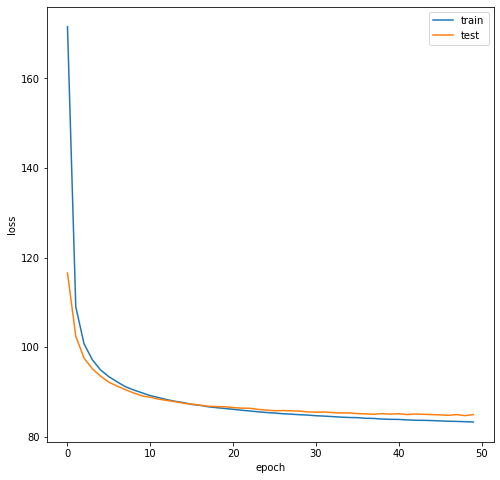

In [185]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))


def sample(model):
  colab_utils.imshow(model.sample().reshape(28, 28))


def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

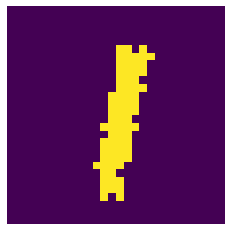

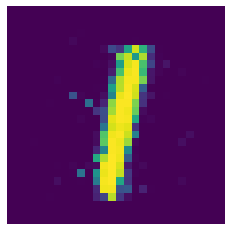

In [190]:
show_random(model, test_loader.dataset)

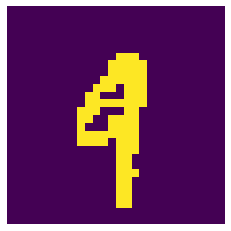

In [193]:
sample(model)

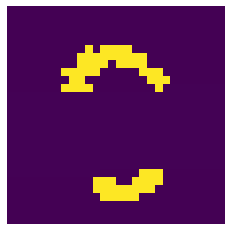

Conditional Samples:


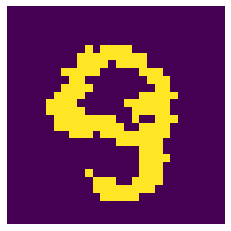

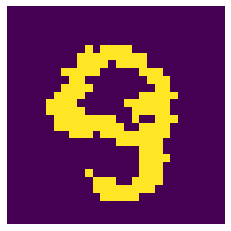

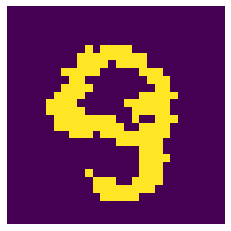

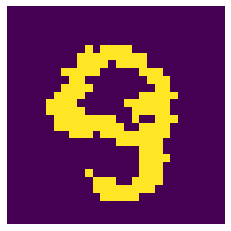

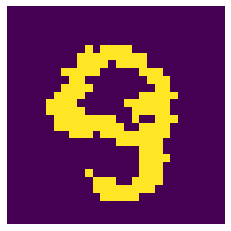

In [195]:
conditional_sample_random(model, test_loader.dataset)